In [ ]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph tavily-python beautifulsoup4

In [ ]:
import os

from dotenv import load_dotenv
from typing import List
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END


In [ ]:
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

In [164]:
import requests
import json
from pydantic import BaseModel
from typing import List, Optional
from datetime import datetime

class Lovhjemmel(BaseModel):
    Lovhjemmel: str
    LovhjemmelUrl: Optional[str]

class Utfalltekst(BaseModel):
    Innholdstype: Optional[str]
    Tittel: Optional[str]
    Beskrivelse: Optional[str]

class Utfall(BaseModel):
    Utfallverdi: bool
    Utfalltype: str
    Utfalltypekode: str
    Utfalltekst: Optional[Utfalltekst]

class Sjekkpunkt(BaseModel):
    Id: str
    Navn: str
    Beskrivelse: Optional[str]
    Lovhjemmel: List[Lovhjemmel]
    Utfall: List[Utfall]
    Undersjekkpunkter: List["Sjekkpunkt"] = []

    def __hash__(self):
        return hash(self.Id)

    class Config:
        frozen = True




def retrieve_current_national_checklist() -> list[Sjekkpunkt]:
    url = "https://sjekkliste-bygg-api.ft.dibk.no/api/sjekkliste"
    response = requests.get(url)
    data = response.json()
    json_data = [json.dumps(item) for item in data]
    checklist = []
    print(len(json_data))
    for item in json_data:
        try:
            checklist.append(Sjekkpunkt.model_validate_json(item))
        except Exception as e:
            print(f"Error: {e}")
            print(f"Item: {item}")

    unique_checklist = set()
    for item in set(checklist):
        if not any(item.Id == x.Id for x in unique_checklist):
            unique_checklist.add(item)
    return list(unique_checklist)
checklist = retrieve_current_national_checklist()
len(checklist)


432
Error: 7 validation errors for Sjekkpunkt
Beskrivelse
  Field required [type=missing, input_value={'SjekkId': 11789, 'Id': ...lge': 7, 'Metadata': []}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/missing
Utfall.0.Utfalltekst.Innholdstype
  Field required [type=missing, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/missing
Utfall.0.Utfalltekst.Tittel
  Field required [type=missing, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/missing
Utfall.0.Utfalltekst.Beskrivelse
  Field required [type=missing, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/missing
Undersjekkpunkter.0.Beskrivelse
  Field required [type=missing, input_value={'SjekkId': 12547, 'Id': ...lge': 8, 'Metadata': []}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/missing
Undersjekk

29

## CRAG

In [165]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://lovdata.no/dokument/NL/lov/2008-06-27-71/*#&#x2a;",
    "https://www.dibk.no/regelverk/byggteknisk-forskrift-tek17",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()


### Retrieval Grader

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))


### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain.schema import Document

# Prompt
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:"""),
    ]
)

# LLM
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)


### Question Re-writer

# LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})


### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

def retrieve_relevant_documents(state):
    return []


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["retrieval_state"]["question"]
    print(f"Question: {question}")

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    retrieval_state = {"documents": documents, "question": question}
    state["retrieval_state"] = retrieval_state
    return state


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["retrieval_state"]["question"]
    documents = state["retrieval_state"]["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    retrieval_state = {"documents": documents, "question": question, "generation": generation}
    state["retrieval_state"] = retrieval_state
    return state


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["retrieval_state"]["question"]
    documents = state["retrieval_state"]["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    retrieval_state = {"documents": filtered_docs, "question": question, "web_search": web_search}
    state["retrieval_state"] = retrieval_state
    return state


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["retrieval_state"]["question"]
    documents = state["retrieval_state"]["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    retrieval_state = {"documents": documents, "question": better_question}
    state["retrieval_state"] = retrieval_state
    return state


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["retrieval_state"]["question"]
    documents = state["retrieval_state"]["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    retrieval_state = {"documents": documents, "question": question}
    state["retrieval_state"] = retrieval_state
    return state


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["retrieval_state"]["question"]
    web_search = state["retrieval_state"]["web_search"]
    state["retrieval_state"]["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

binary_score='no'
I don't know.


## Reflexion

In [166]:
class MarkedCheckpoint(BaseModel):
    status: str = Field(description="The status of the checkpoint either being Correct, Uncertain, or Incorrect based on the content of the application.")
    reason: str = Field(description="The reason for the status of the checkpoint.")
    


In [167]:
import json

def fill_out_checklist_responder(state):
    print("\n---Filling out Checklist---")
    user_applications = state['user_application_documents']
    checklist = state['checklist']
    retrieval_state = state['retrieval_state']
    documents = retrieval_state['documents']  # Retrieved laws and regulations

    # Combine all application documents into one string
    application_text = "\n\n".join(user_applications)
    # Combine all retrieved documents into one string
    laws_and_regulations = "\n\n".join([doc.page_content for doc in documents])

    marked_checklist = []
    need_retrieval = False  # Flag to determine if retrieval is needed

    # Check if there is feedback from the revisor
    feedback = state.get('revisor_feedback', None)

    for idx, checkpoint in enumerate(checklist):
        # If there is feedback for this checkpoint, use it
        if feedback:
            feedback_item = next((item for item in feedback if item['checkpoint'] == checkpoint), None)
        else:
            feedback_item = None

        # Determine if laws are available
        laws_available = bool(laws_and_regulations.strip())

        if feedback_item:
            # Use the feedback to improve the marked checklist
            previous_status = feedback_item.get('status', 'Uncertain')
            previous_reason = feedback_item.get('reason', '')
        else:
            previous_status = 'Uncertain'
            previous_reason = ''

        # Construct the prompt
        if not laws_available:
            prompt = f"""
You are an expert in building regulations and codes.

First, read the following application documents:

{application_text}

Currently, you do not have access to the relevant laws and regulations.

Now, evaluate the following checkpoint:

"{checkpoint}"

Using only the information from the application, determine whether you have enough information to assess this checkpoint. If you don't have enough information due to the absence of laws and regulations, state that you need more information.

Provide your answer in the following JSON format:

{{
  "status": "Uncertain",
  "reason": "Your reason here, indicating the need for more information."
}}
"""
        else:
            prompt = f"""
You are an expert in building regulations and codes.

First, read the following application documents:

{application_text}

Then, review the following laws and regulations:

{laws_and_regulations}

Previously, the status for the checkpoint was '{previous_status}' with the reason: '{previous_reason}'.

Now, re-evaluate the following checkpoint, taking into account this feedback:

"{checkpoint}"

Using the information from the application and the laws, determine whether the checkpoint is 'Correct', 'Incorrect', or 'Uncertain'. Provide a revised reason for your determination.

Provide your answer in the following JSON format:

{{
  "status": "Correct" or "Incorrect" or "Uncertain",
  "reason": "Your reason here."
}}
"""

        # Get the response from the LLM
        response = llm.predict(prompt)
        # Parse the response
        try:
            result = json.loads(response)
            marked_checkpoint = MarkedCheckpoint(
                status=result.get('status', 'Uncertain'),
                reason=result.get('reason', 'No reason provided.')
            )
            # If status is 'Uncertain' due to lack of information, set the retrieval flag
            if marked_checkpoint.status == 'Uncertain' and 'more information' in marked_checkpoint.reason.lower():
                need_retrieval = True
        except json.JSONDecodeError:
            # If parsing fails, mark as Uncertain and set retrieval flag
            marked_checkpoint = MarkedCheckpoint(
                status='Uncertain',
                reason='Could not parse LLM response.'
            )
            need_retrieval = True
        marked_checklist.append(marked_checkpoint)

    # Update the state with the marked checklist
    state['marked_checklist'] = marked_checklist
    state['should_retrieve'] = need_retrieval

    if need_retrieval:
        print("Writing questions for retrieval.")
        response = llm.predict(f"Write questions for uncertain checkpoints to retrieve more information: {marked_checklist} ")
        print(f"question for retrieval: {response}")
        state['retrieval_state']['question'] = response

    # Clear the feedback after using it
    if 'revisor_feedback' in state:
        del state['revisor_feedback']
    return state


def decide_next_step_after_fill_out(state):
    """Decide whether to proceed to 'retrieve' or 'marked_checklist_revisor'."""
    if state['should_retrieve']:
        print("---DECISION: Need more information, proceeding to 'retrieve'---")
        return "retrieve"
    else:
        print("---DECISION: Enough information, proceeding to 'marked_checklist_revisor'---")
        return "marked_checklist_revisor"


def decide_to_continue_after_revisor(state):
    """Decide whether to continue processing or end."""
    if state.get('should_continue'):
        print("---DECISION: Looping back to 'fill_out_checklist_responder'---")
        return "fill_out_checklist_responder"
    else:
        print("---DECISION: Process complete---")
        return END


def marked_checklist_revisor(state):
    """Node that revises the marked checklist and provides feedback."""
    print("\n---Marked Checklist Revisor---")
    marked_checklist: list[MarkedCheckpoint] = state['marked_checklist']
    checklist: list[Sjekkpunkt] = state['checklist']
    application_text = "\n\n".join(state['user_application_documents'])
    # Prepare the checklist items for review 
    checklist_with_marks = [
        {
            "checkpoint": checkpoint,
            "status": marked_checkpoint.status,
            "reason": marked_checkpoint.reason
        } for checkpoint, marked_checkpoint in zip(checklist, marked_checklist)
    ]
    

    # Construct the prompt for the LLM
    prompt = f"""
You are an expert reviewer in building regulations.

Review the following marked checklist items for correctness and consistency:

{checklist_with_marks}



Here is the application text:

{application_text}

If any of the statuses or reasons seem incorrect or inconsistent, provide the corrected status and reason for those items. If everything is correct, simply reply 'All good'.

Provide your corrections in the same JSON format as above.
"""

    # Get the response from the LLM
    response = llm.predict(prompt)

    if 'All good' in response.strip():
        # No revisions needed
        print("No revisions needed.")
        state['should_continue'] = False
    else:
        try:
            revised_items = json.loads(response)
            # Store the feedback in the state
            state['revisor_feedback'] = revised_items
            state['should_continue'] = True
            print("Feedback provided by revisor.")
        except json.JSONDecodeError:
            print("Could not parse revision response.")
            state['should_continue'] = False  # End process if parsing failed

    return state


In [168]:
class MarkedCheckpoint(BaseModel):
    status: str = Field(description="The status of the checkpoint either being Correct, Uncertain, or Incorrect based on the content of the application.")
    reason: str = Field(description="The reason for the status of the checkpoint.")
    

class RetrievalState(TypedDict):
    """
    Represents the state of our retrieval graph using CRAG.

    Attributes:
        question: question
        answer: LLMs answer based on the question and context
        web_search: whether to add search
        documents: list of documents
    """
    question: str
    generation: str
    web_search: str
    documents: list[str]


class AgentState(TypedDict):
    user_application_documents: list[str]
    retrieval_state: RetrievalState
    checklist: list[Sjekkpunkt]
    marked_checklist: list[MarkedCheckpoint]
    revisor_feedback: List[dict]
    should_retrieve: bool 
    should_continue: bool 



In [169]:
# Initialize the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search_node", web_search)
workflow.add_node("fill_out_checklist_responder", fill_out_checklist_responder)
workflow.add_node("marked_checklist_revisor", marked_checklist_revisor)

# Build edges
workflow.add_edge(START, "fill_out_checklist_responder")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", "fill_out_checklist_responder")
workflow.add_conditional_edges(
    "fill_out_checklist_responder",
    decide_next_step_after_fill_out,
    {
        "retrieve": "retrieve",
        "marked_checklist_revisor": "marked_checklist_revisor",
    },
)
workflow.add_conditional_edges(
    "marked_checklist_revisor",
    decide_to_continue_after_revisor,
    {
        "fill_out_checklist_responder": "fill_out_checklist_responder",
        END: END,
    },
)


# Compile the graph
app = workflow.compile()

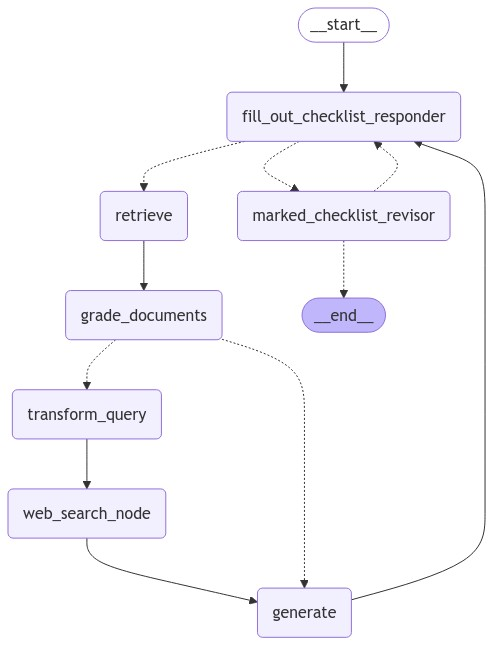

In [170]:
from IPython.display import Image

def visualize(graph: StateGraph) -> None:
    return Image(graph.get_graph().draw_mermaid_png())
visualize(app)

In [171]:
# Sample user application documents
user_application_documents = [
    "The applicant wants to build a two-story house with a basement. The proposed building height is 9 meters. The building will be located 5 meters from the property line.",
    "The applicant intends to add a fourth floor to an existing three-story building, increasing the total height to 15 meters. No environmental impact assessment has been provided."
    "The building will be constructed 10 meters from the riverbank",
]

# Initial state
initial_state = {
    'user_application_documents': user_application_documents,
    'retrieval_state': {
        'question': "Building regulations for residential constructions",
        'generation': '',
        'web_search': '',
        'documents': []
    },
    'checklist': checklist,
    'marked_checklist': [],
    'reflection': '',
    'grading': '',
    'should_retrieve': True,
    'should_continue': True,

}

# Run the agent
final_state = app.invoke(initial_state)


---Filling out Checklist---
Writing questions for retrieval.
question for retrieval: Certainly! Here are some questions you can use to gather more information at uncertain checkpoints:

1. **Clarification Questions:**
   - Can you elaborate on what you mean by that?
   - Could you provide an example to illustrate your point?
   - What specific aspects are you uncertain about?

2. **Contextual Questions:**
   - What led you to this conclusion?
   - How does this relate to the previous information we discussed?
   - Are there any external factors influencing your perspective?

3. **Detail-Oriented Questions:**
   - What are the key factors that contribute to this uncertainty?
   - Can you break down the components of this issue for me?
   - What data or evidence do you have to support this?

4. **Perspective Questions:**
   - How do you think others might view this situation?
   - What alternative viewpoints should we consider?
   - Have you encountered similar situations before? How di

KeyboardInterrupt: 

In [ ]:
final_state